In [6]:
import scipy.io
data = scipy.io.loadmat('Data_ankle.mat')
ankle_data= data['ankle_data']
print(ankle_data.shape)

(48000, 7)


In [7]:
import pandas as pd

### Load in DataFrame

In [8]:
# Define column names
column_names = [
    'time', 
    'vgrf',  # vertical ground reaction force
    'trunk_angle',
    'hip_angle', 
    'knee_angle', 
    'ankle_angle', 
    'joint_moment'
]
df = pd.DataFrame(ankle_data, columns=column_names )
df.head()

,time,vgrf,trunk_angle,hip_angle,knee_angle,ankle_angle,joint_moment
0,0.00,-10.321381,-0.094286,0.292974,0.825063,-1.492588,-2.011628
1,0.01,-7.990312,-0.096174,0.293179,0.822469,-1.493192,-3.655209
2,0.02,-6.208738,-0.096449,0.294008,0.810997,-1.495867,-5.786433
3,0.03,-5.126637,-0.097196,0.295568,0.785731,-1.501793,-6.190008
4,0.04,-4.774037,-0.095624,0.297472,0.745707,-1.511208,-5.542868


In [9]:
df.describe()


,time,vgrf,trunk_angle,hip_angle,knee_angle,ankle_angle,joint_moment
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,239.995000,355.143317,-0.051574,0.087569,0.461276,-1.557203,31.054144
std,138.565508,313.909396,0.042220,0.176258,0.325162,0.151105,36.939725
min,0.000000,-28.749562,-0.148580,-0.239775,0.019355,-1.862011,-15.414847
25%,119.997500,-3.361821,-0.084834,-0.082198,0.230068,-1.685668,-0.004131
50%,239.995000,437.072999,-0.059513,0.117106,0.328396,-1.571418,12.770055
75%,359.992500,652.307594,-0.017608,0.258930,0.670041,-1.474308,57.552954
max,479.990000,883.175946,0.071489,0.358529,1.209329,-1.138431,125.762815


### Normalize the DataSet

In [25]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler


# Features and targets
features = df.drop(columns=['joint_moment'])
targets = df['joint_moment']

# Normalize features
scaler = MinMaxScaler()
scaler2 = StandardScaler()

normalized_features = scaler2.fit_transform(features)
normalized_features_df = pd.DataFrame(normalized_features, columns=features.columns)
#normalized_features_df.insert(0, 'time', df['time'])
print(normalized_features_df.head())
 


       time      vgrf  trunk_angle  hip_angle  knee_angle  ankle_angle
0 -1.732015 -1.164248    -1.011654   1.165376    1.118800     0.427622
1 -1.731943 -1.156822    -1.056365   1.166540    1.110820     0.423625
2 -1.731870 -1.151147    -1.062878   1.171241    1.075539     0.405926
3 -1.731798 -1.147700    -1.080574   1.180092    0.997836     0.366702
4 -1.731726 -1.146576    -1.043329   1.190897    0.874748     0.304399


### Train Test Split

In [26]:
train_size = int(0.8 * len(normalized_features_df))
train_features = normalized_features_df.iloc[:train_size]
test_features = normalized_features_df.iloc[train_size:]
train_targets = targets.iloc[:train_size]
test_targets = targets.iloc[train_size:]



In [27]:
test_features = test_features[:40]
test_targets = test_targets[:40]

In [28]:
len(train_targets), len(test_targets)

(38400, 40)

### NN models

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten

def create_cnn_model(input_shape):
    model = Sequential()
    # Add padding='same' to prevent excessive downsampling
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))  # Output layer for joint moment prediction
    # model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss='mse')
    return model

In [35]:
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def create_rnn_model2(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))  # Output layer for joint moment prediction
    model.compile(optimizer='adam', loss='mse')
    return model


def create_rnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [36]:
def extract_data_for_combination(columns):
    X_train = train_features[columns].values
    y_train = train_targets.values
    X_test = test_features[columns].values
    y_test = test_targets.values
    # Reshape for RNN
    X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train_rnn, y_train, X_test_rnn, y_test

### TRAINing

In [37]:
from sklearn.metrics import mean_squared_error

# Function to train and evaluate models
def train_and_evaluate_model(train_features, test_features, train_targets, test_targets, model_fn):

    X_train_rnn, y_train, X_test_rnn, y_test = extract_data_for_combination(['ankle_angle', 'knee_angle', 'hip_angle'])
    

    #train_features_reshaped = train_features.values.reshape((train_features.shape[0], 1, train_features.shape[1]))
    #test_features_reshaped = test_features.values.reshape((test_features.shape[0], 1, train_features.shape[1]))
    
    rnn_model = create_rnn_model(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))

    model = model_fn(train_features_reshaped.shape[1:])

    history = rnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)
    
    #history = model.fit(train_features_reshaped, train_targets, epochs=53, batch_size=64, validation_split=0.2 ,  verbose=1)
    #predictions = model.predict(test_features_reshaped).flatten()

    mse = mean_squared_error(test_targets, predictions)
    
    return mse, predictions, history

# Define input combinations
input_combinations = {
    
    'all_angles_and_vgrf': ['ankle_angle', 'knee_angle', 'hip_angle']
}


# 'ankle_angle_only': ['ankle_angle'],
# 'ankle_angle_and_vgrf':['vgrf','ankle_angle',],
# 'all_joint_angles': ['trunk_angle', 'hip_angle', 'knee_angle', 'ankle_angle'],
# Evaluate different input combinations


results = {}
for key, columns in input_combinations.items():
   
    rnn_mse, rnn_predictions, rnn_history = train_and_evaluate_model(
        train_features[columns], 
        test_features[columns], 
        train_targets, 
        test_targets, 
        create_rnn_model, 
    )
    
    results[key] = {
        'rnn_mse': rnn_mse,
        'rnn_predictions': rnn_predictions,
        'rnn_history': rnn_history
    }
    
    print(f"Input Combination: {key}")
    print(f"RNN - MSE: {rnn_mse}")


Epoch 1/50
480/480 [==============================] - 2s 3ms/step - loss: 1569.3822 - val_loss: 318.0306
Epoch 2/50
480/480 [==============================] - 0s 744us/step - loss: 141.4241 - val_loss: 95.7371
Epoch 3/50
480/480 [==============================] - 0s 720us/step - loss: 96.0515 - val_loss: 83.6961
Epoch 4/50
480/480 [==============================] - 0s 911us/step - loss: 85.5490 - val_loss: 75.7222
Epoch 5/50
480/480 [==============================] - 0s 692us/step - loss: 78.1564 - val_loss: 67.1757
Epoch 6/50
480/480 [==============================] - 0s 717us/step - loss: 74.7809 - val_loss: 61.8945
Epoch 7/50
480/480 [==============================] - 0s 713us/step - loss: 70.8005 - val_loss: 57.9056
Epoch 8/50
480/480 [==============================] - 0s 727us/step - loss: 68.7900 - val_loss: 55.7276
Epoch 9/50
480/480 [==============================] - 0s 691us/step - loss: 66.9593 - val_loss: 53.5465
Epoch 10/50
480/480 [==============================] - 0s 763u

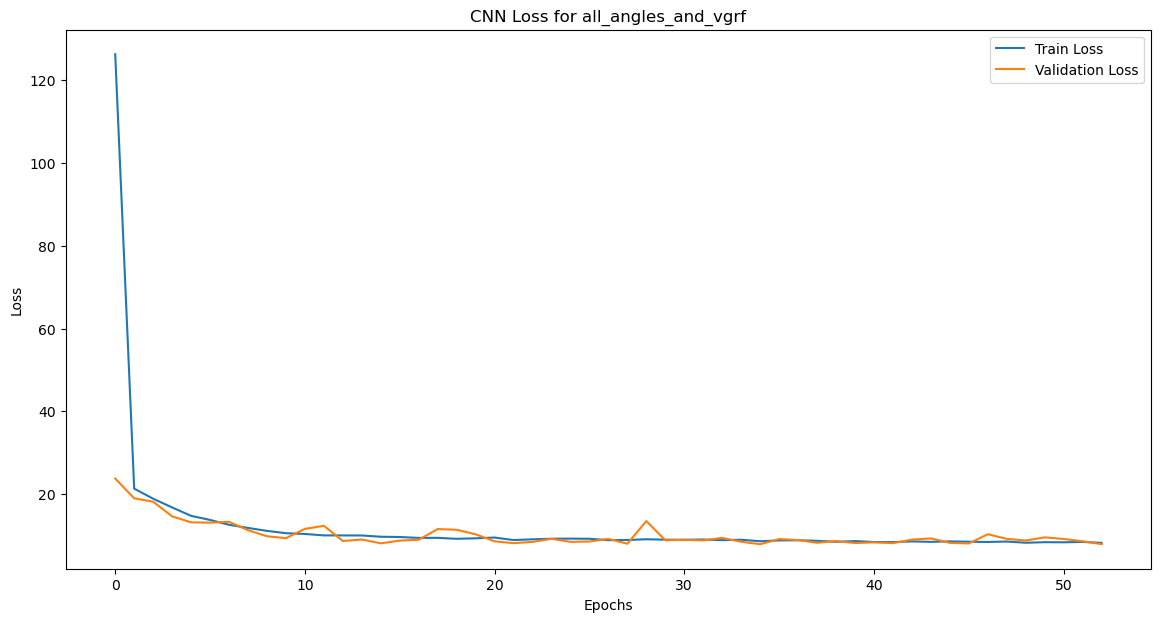

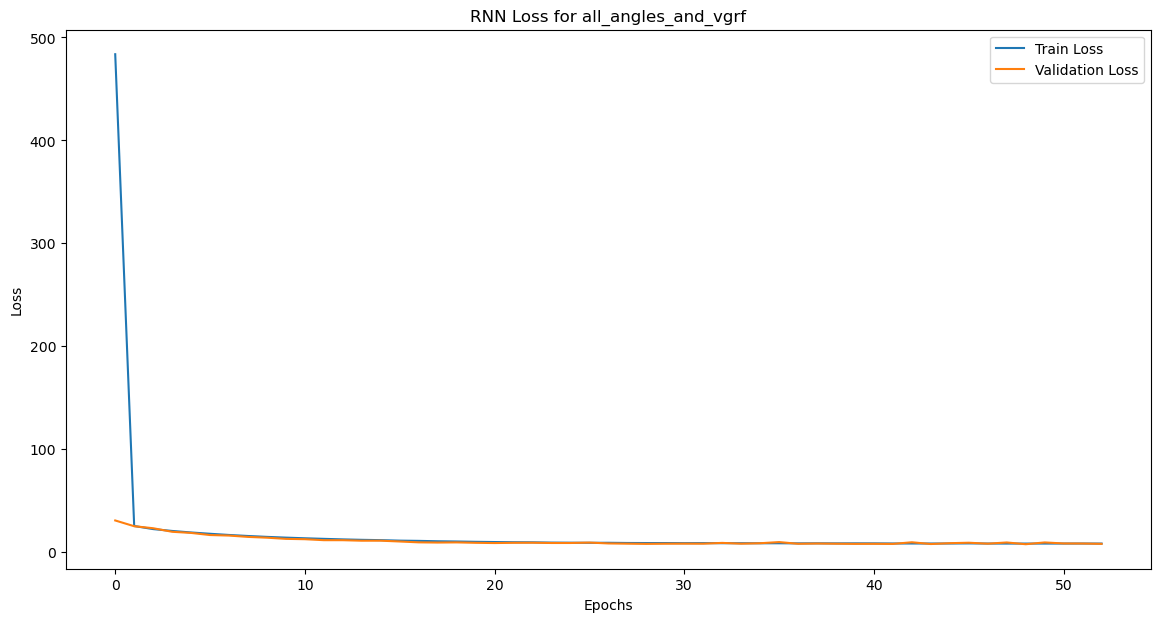

In [142]:
# Visualization of training and validation loss
import matplotlib.pyplot as plt

for key, result in results.items():
    # CNN loss
    plt.figure(figsize=(14, 7))
    plt.plot(result['cnn_history'].history['loss'], label='Train Loss')
    plt.plot(result['cnn_history'].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'CNN Loss for {key}')
    plt.legend()
    plt.show()
    
    # RNN loss
    plt.figure(figsize=(14, 7))
    plt.plot(result['rnn_history'].history['loss'], label='Train Loss')
    plt.plot(result['rnn_history'].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'RNN Loss for {key}')
    plt.legend()
    plt.show()


In [143]:
mse_values = {key: {'cnn_mse': result['cnn_mse'], 'rnn_mse': result['rnn_mse']} for key, result in results.items()}
print(mse_values)

{'all_angles_and_vgrf': {'cnn_mse': 2.2782825593320757, 'rnn_mse': 2.008846596498778}}


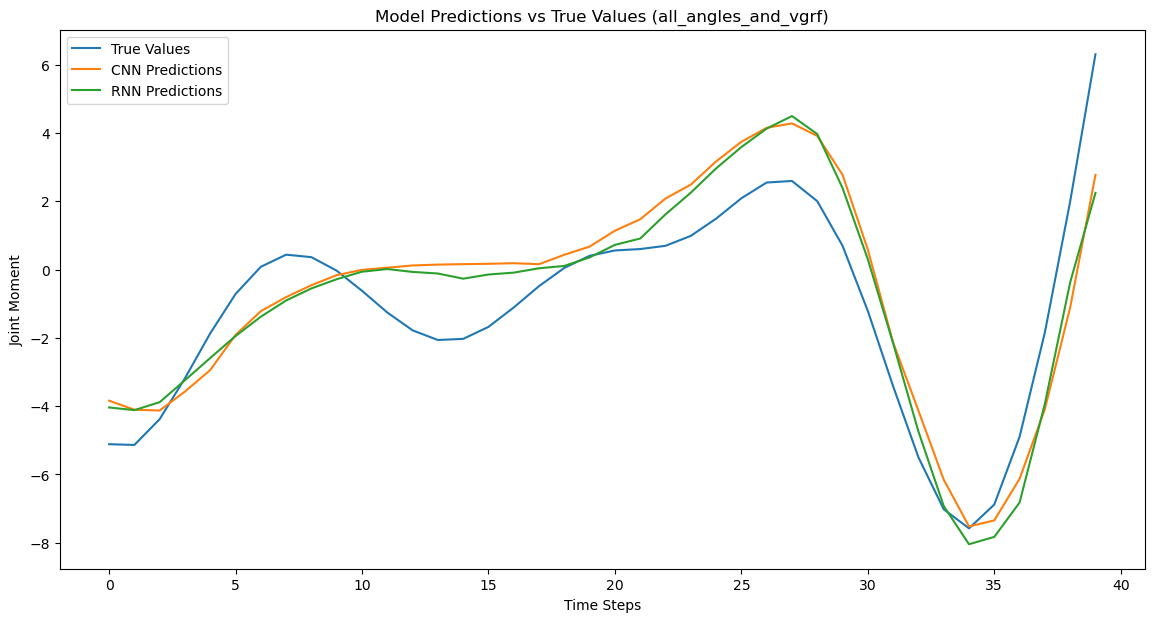

In [144]:
import matplotlib.pyplot as plt

for key, result in results.items():
    plt.figure(figsize=(14, 7))
    plt.plot(test_targets.values, label='True Values')
    plt.plot(result['cnn_predictions'], label='CNN Predictions')
    plt.plot(result['rnn_predictions'], label='RNN Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Joint Moment')
    plt.title(f'Model Predictions vs True Values ({key})')
    plt.legend()
    plt.show()